# Grad-CAM Visualization – ODIR-5K (Multi-Label)

## Objective
This notebook applies **Grad-CAM (Gradient-weighted Class Activation Mapping)** to visualize which retinal regions influence the model’s predictions.

Unlike single-label classification, ocular diseases may **co-occur**.
Therefore:
- Multi-label predictions are threshold-based
- Grad-CAM is generated **per predicted disease**
- Confidence scores are shown alongside visual explanations

This improves **interpretability, clinical trust, and model transparency**.

## Section 1 - Import Required Libraries and set paths

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torchvision import models, transforms
from PIL import Image
from pathlib import Path

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Paths, Labels & Configuration

In [15]:
PROJECT_ROOT = Path.cwd().parent
IMAGE_ROOT = PROJECT_ROOT / "data" / "ODIR-5K" / "ODIR-5K" / "Training Images"
CHECKPOINT_PATH = PROJECT_ROOT / "checkpoints" / "efficientnet_b0" / "efficientnet_b0_odir.pth"

label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

disease_map = {
    "N": "Normal",
    "D": "Diabetes",
    "G": "Glaucoma",
    "C": "Cataract",
    "A": "Age-related Macular Degeneration",
    "H": "Hypertension",
    "M": "Pathological Myopia",
    "O": "Other Abnormalities"
}

## Load Trained EfficientNet-B0 Model

In [16]:
model = models.efficientnet_b0(
    weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
)

model.classifier[1] = torch.nn.Linear(
    model.classifier[1].in_features,
    len(label_cols)
)

model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.to(device)
model.eval()

print("EfficientNet-B0 loaded successfully.")

C:\Users\ibaan\AppData\Local\Temp\ipykernel_10560\3302661048.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH, map_locat

EfficientNet-B0 loaded successfully.


## Section 2 - Image Preprocessing

In [17]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Section 3 - Grad-CAM Implementation

In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self._save_activations)
        target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, target_class):
        self.model.zero_grad()
        outputs = self.model(input_tensor)
        outputs[:, target_class].backward(retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam[0].detach().cpu().numpy()

## Target Layer Selection

In [19]:
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

## Section 4 - Load Image & Multi-Label Prediction

In [31]:
# Select one image
image_path = list(IMAGE_ROOT.iterdir())[0]
original_image = Image.open(image_path).convert("RGB")

input_tensor = transform(original_image).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.sigmoid(logits)

threshold = 0.5
predicted_indices = (probs >= threshold).nonzero(as_tuple=True)[1]

print("Predicted diseases:")
for idx in predicted_indices:
    code = label_cols[idx]
    print(f"- {disease_map[code]} ({probs[0, idx].item():.2f})")

Predicted diseases:
- Cataract (0.97)


## Section 5 - Grad-CAM per Predicted Disease

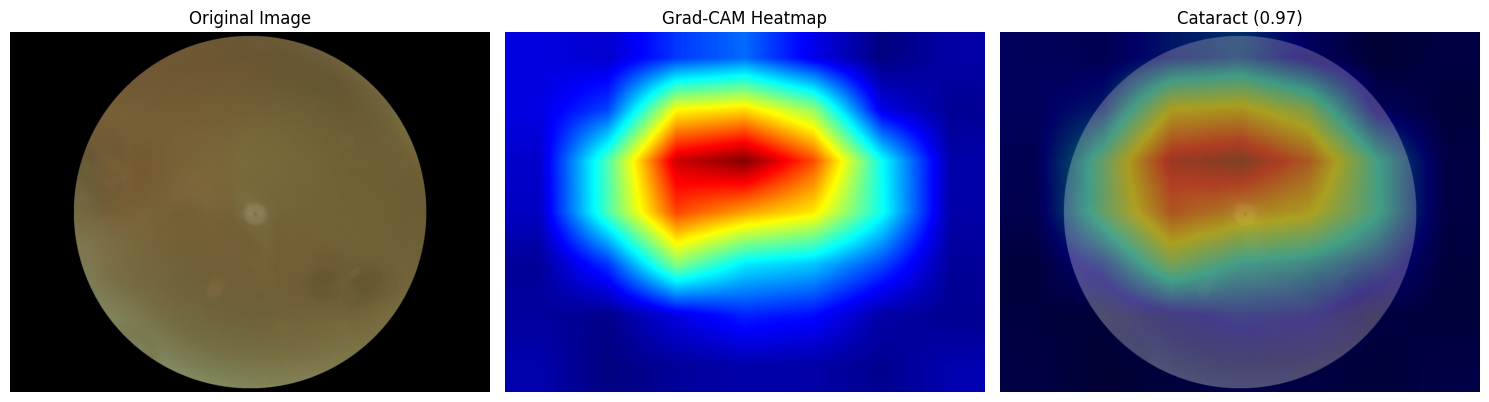

In [21]:
# Visualization Loop
original_np = np.array(original_image)

for idx in predicted_indices:
    disease_code = label_cols[idx]
    disease_name = disease_map[disease_code]
    confidence = probs[0, idx].item()

    cam = gradcam.generate(input_tensor, idx)
    cam_resized = cv2.resize(cam, original_image.size)

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized),
        cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(original_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"{disease_name} ({confidence:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Image 1: 86_right.jpg


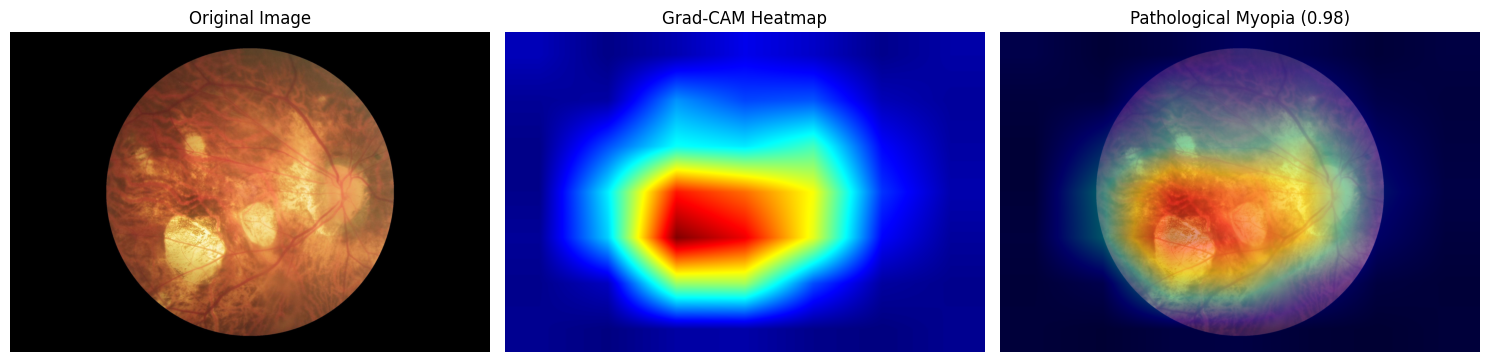


Image 2: 79_right.jpg


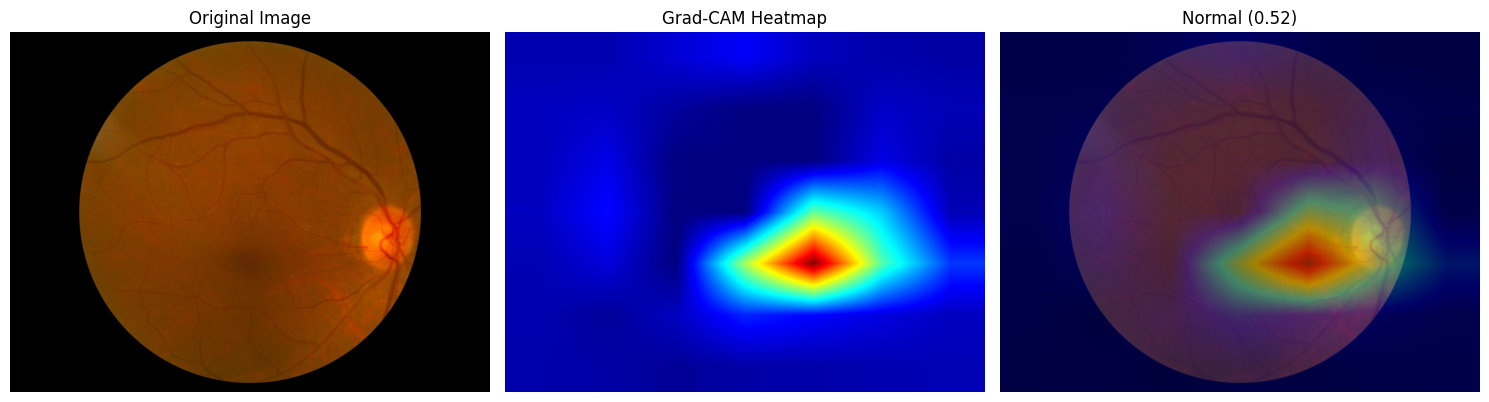


Image 3: 2041_left.jpg


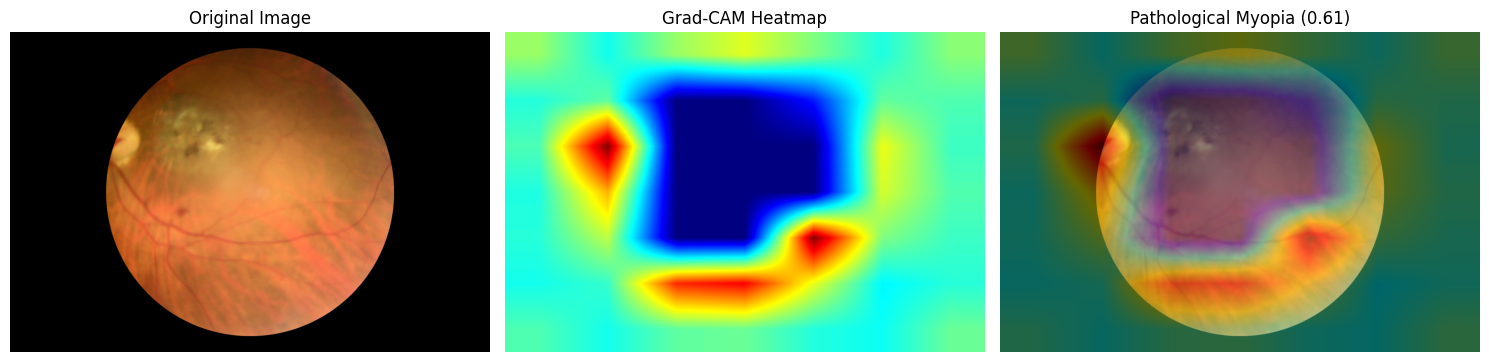

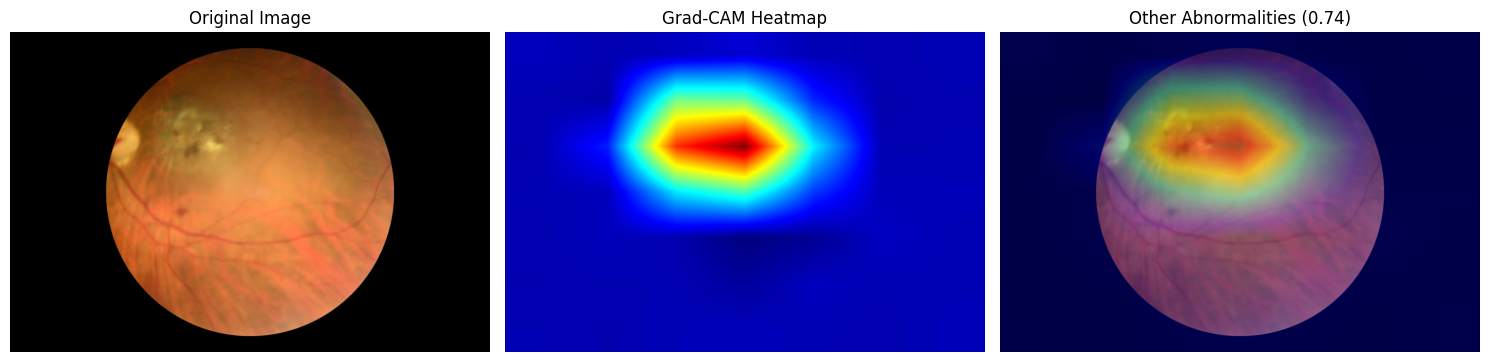

In [34]:
import random

# Select 3 random images from the dataset
all_images = list(IMAGE_ROOT.iterdir())
random_images = random.sample(all_images, 3)

threshold = 0.5  # Multi-label threshold

for img_idx, image_path in enumerate(random_images, start=1):
    print(f"\nImage {img_idx}: {image_path.name}")

    # Load & preprocess image
    original_image = Image.open(image_path).convert("RGB")
    original_np = np.array(original_image)

    input_tensor = transform(original_image).unsqueeze(0).to(device)

    # Multi-label prediction
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)

    predicted_indices = (probs >= threshold).nonzero(as_tuple=True)[1]

    if len(predicted_indices) == 0:
        print("No disease detected above threshold.")
        continue

    # Grad-CAM per predicted disease
    for idx in predicted_indices:
        disease_code = label_cols[idx]
        disease_name = disease_map[disease_code]
        confidence = probs[0, idx].item()

        cam = gradcam.generate(input_tensor, idx)
        cam_resized = cv2.resize(cam, original_image.size)

        heatmap = cv2.applyColorMap(
            np.uint8(255 * cam_resized),
            cv2.COLORMAP_JET
        )
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        overlay = cv2.addWeighted(original_np, 0.6, heatmap, 0.4, 0)

        # Visualization
        plt.figure(figsize=(15, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(original_np)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap)
        plt.title("Grad-CAM Heatmap")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title(f"{disease_name} ({confidence:.2f})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

## Interpretation

Each Grad-CAM visualization highlights the retinal regions that most influenced the prediction of a specific disease. Since multiple ocular conditions may co-exist, visual explanations are generated separately per disease, ensuring clinically meaningful interpretation rather than forced single-label attribution.

## Conclusion

- Multi-label Grad-CAM provides disease-specific visual explanations
- The model focuses on anatomically relevant retinal regions
- This enhances transparency, trust, and clinical usability

Grad-CAM serves as a critical step toward explainable AI in ophthalmology.